In [1]:
import numpy as np
import cv2

import random
from deap import base, creator, tools, algorithms
import matplotlib.pyplot as plt
from skimage.filters.rank import entropy
from skimage.morphology import disk

# SBOX

In [18]:
def Sbox(image):
    
    sbox = [    0x63, 0x7C, 0x77, 0x7B, 0xF2, 0x6B, 0x6F, 0xC5, 0x30, 0x01, 0x67, 0x2B, 0xFE, 0xD7, 0xAB, 0x76,
                0xCA, 0x82, 0xC9, 0x7D, 0xFA, 0x59, 0x47, 0xF0, 0xAD, 0xD4, 0xA2, 0xAF, 0x9C, 0xA4, 0x72, 0xC0,
                0xB7, 0xFD, 0x93, 0x26, 0x36, 0x3F, 0xF7, 0xCC, 0x34, 0xA5, 0xE5, 0xF1, 0x71, 0xD8, 0x31, 0x15,
                0x04, 0xC7, 0x23, 0xC3, 0x18, 0x96, 0x05, 0x9A, 0x07, 0x12, 0x80, 0xE2, 0xEB, 0x27, 0xB2, 0x75,
                0x09, 0x83, 0x2C, 0x1A, 0x1B, 0x6E, 0x5A, 0xA0, 0x52, 0x3B, 0xD6, 0xB3, 0x29, 0xE3, 0x2F, 0x84,
                0x53, 0xD1, 0x00, 0xED, 0x20, 0xFC, 0xB1, 0x5B, 0x6A, 0xCB, 0xBE, 0x39, 0x4A, 0x4C, 0x58, 0xCF,
                0xD0, 0xEF, 0xAA, 0xFB, 0x43, 0x4D, 0x33, 0x85, 0x45, 0xF9, 0x02, 0x7F, 0x50, 0x3C, 0x9F, 0xA8,
                0x51, 0xA3, 0x40, 0x8F, 0x92, 0x9D, 0x38, 0xF5, 0xBC, 0xB6, 0xDA, 0x21, 0x10, 0xFF, 0xF3, 0xD2,
                0xCD, 0x0C, 0x13, 0xEC, 0x5F, 0x97, 0x44, 0x17, 0xC4, 0xA7, 0x7E, 0x3D, 0x64, 0x5D, 0x19, 0x73,
                0x60, 0x81, 0x4F, 0xDC, 0x22, 0x2A, 0x90, 0x88, 0x46, 0xEE, 0xB8, 0x14, 0xDE, 0x5E, 0x0B, 0xDB,
                0xE0, 0x32, 0x3A, 0x0A, 0x49, 0x06, 0x24, 0x5C, 0xC2, 0xD3, 0xAC, 0x62, 0x91, 0x95, 0xE4, 0x79,
                0xE7, 0xC8, 0x37, 0x6D, 0x8D, 0xD5, 0x4E, 0xA9, 0x6C, 0x56, 0xF4, 0xEA, 0x65, 0x7A, 0xAE, 0x08,
                0xBA, 0x78, 0x25, 0x2E, 0x1C, 0xA6, 0xB4, 0xC6, 0xE8, 0xDD, 0x74, 0x1F, 0x4B, 0xBD, 0x8B, 0x8A,
                0x70, 0x3E, 0xB5, 0x66, 0x48, 0x03, 0xF6, 0x0E, 0x61, 0x35, 0x57, 0xB9, 0x86, 0xC1, 0x1D, 0x9E,
                0xE1, 0xF8, 0x98, 0x11, 0x69, 0xD9, 0x8E, 0x94, 0x9B, 0x1E, 0x87, 0xE9, 0xCE, 0x55, 0x28, 0xDF,
                0x8C, 0xA1, 0x89, 0x0D, 0xBF, 0xE6, 0x42, 0x68, 0x41, 0x99, 0x2D, 0x0F, 0xB0, 0x54, 0xBB, 0x16 ]
    
    
        
#     new_image = np.array([ sbox[i] for i in np.flatten(image)], dtype=np.uint8)

# [[int(y) for y in x] for x in values]

    new_image = np.array([[sbox[i] for i in j] for j in image], dtype=np.uint8)

    
        
    return new_image



def invSbox(image):

    invsbox = [   0x52, 0x09, 0x6A, 0xD5, 0x30, 0x36, 0xA5, 0x38, 0xBF, 0x40, 0xA3, 0x9E, 0x81, 0xF3, 0xD7, 0xFB,
                0x7C, 0xE3, 0x39, 0x82, 0x9B, 0x2F, 0xFF, 0x87, 0x34, 0x8E, 0x43, 0x44, 0xC4, 0xDE, 0xE9, 0xCB,
                0x54, 0x7B, 0x94, 0x32, 0xA6, 0xC2, 0x23, 0x3D, 0xEE, 0x4C, 0x95, 0x0B, 0x42, 0xFA, 0xC3, 0x4E,
                0x08, 0x2E, 0xA1, 0x66, 0x28, 0xD9, 0x24, 0xB2, 0x76, 0x5B, 0xA2, 0x49, 0x6D, 0x8B, 0xD1, 0x25,
                0x72, 0xF8, 0xF6, 0x64, 0x86, 0x68, 0x98, 0x16, 0xD4, 0xA4, 0x5C, 0xCC, 0x5D, 0x65, 0xB6, 0x92,
                0x6C, 0x70, 0x48, 0x50, 0xFD, 0xED, 0xB9, 0xDA, 0x5E, 0x15, 0x46, 0x57, 0xA7, 0x8D, 0x9D, 0x84,
                0x90, 0xD8, 0xAB, 0x00, 0x8C, 0xBC, 0xD3, 0x0A, 0xF7, 0xE4, 0x58, 0x05, 0xB8, 0xB3, 0x45, 0x06,
                0xD0, 0x2C, 0x1E, 0x8F, 0xCA, 0x3F, 0x0F, 0x02, 0xC1, 0xAF, 0xBD, 0x03, 0x01, 0x13, 0x8A, 0x6B,
                0x3A, 0x91, 0x11, 0x41, 0x4F, 0x67, 0xDC, 0xEA, 0x97, 0xF2, 0xCF, 0xCE, 0xF0, 0xB4, 0xE6, 0x73,
                0x96, 0xAC, 0x74, 0x22, 0xE7, 0xAD, 0x35, 0x85, 0xE2, 0xF9, 0x37, 0xE8, 0x1C, 0x75, 0xDF, 0x6E,
                0x47, 0xF1, 0x1A, 0x71, 0x1D, 0x29, 0xC5, 0x89, 0x6F, 0xB7, 0x62, 0x0E, 0xAA, 0x18, 0xBE, 0x1B,
                0xFC, 0x56, 0x3E, 0x4B, 0xC6, 0xD2, 0x79, 0x20, 0x9A, 0xDB, 0xC0, 0xFE, 0x78, 0xCD, 0x5A, 0xF4,
                0x1F, 0xDD, 0xA8, 0x33, 0x88, 0x07, 0xC7, 0x31, 0xB1, 0x12, 0x10, 0x59, 0x27, 0x80, 0xEC, 0x5F,
                0x60, 0x51, 0x7F, 0xA9, 0x19, 0xB5, 0x4A, 0x0D, 0x2D, 0xE5, 0x7A, 0x9F, 0x93, 0xC9, 0x9C, 0xEF,
                0xA0, 0xE0, 0x3B, 0x4D, 0xAE, 0x2A, 0xF5, 0xB0, 0xC8, 0xEB, 0xBB, 0x3C, 0x83, 0x53, 0x99, 0x61,
                0x17, 0x2B, 0x04, 0x7E, 0xBA, 0x77, 0xD6, 0x26, 0xE1, 0x69, 0x14, 0x63, 0x55, 0x21, 0x0C, 0x7D ]
    
    
    new_image = np.array([[invsbox[i] for i in j] for j in image], dtype=np.uint8)
    
    return new_image


image = np.mgrid[:10, :10][0]
print(invSbox(Sbox(image)))

[[0 0 0 0 0 0 0 0 0 0]
 [1 1 1 1 1 1 1 1 1 1]
 [2 2 2 2 2 2 2 2 2 2]
 [3 3 3 3 3 3 3 3 3 3]
 [4 4 4 4 4 4 4 4 4 4]
 [5 5 5 5 5 5 5 5 5 5]
 [6 6 6 6 6 6 6 6 6 6]
 [7 7 7 7 7 7 7 7 7 7]
 [8 8 8 8 8 8 8 8 8 8]
 [9 9 9 9 9 9 9 9 9 9]]


In [37]:
def F(sample, K):
    
    if len(sample) != len(K):
        print("Sample and sequence length don't match")
    
    reorder = np.zeros(len(sample), dtype=np.uint8)
        
    for x in range(len(K)):
        
        reorder[K[x]] = sample[x]
    
    return reorder

#################################
# Unscramble
#################################

def invF(sample, K):
    if len(sample) != len(K):
        print("Sample and sequence length don't match")
    
    ordered = np.zeros(len(sample), dtype=np.uint8)
    
    for x in range(len(K)):
        ordered[x] = sample[K[x]]
    
    return ordered

def one_dim_bit_encrypt(image, key, order='C'):
    
    img_arr = np.array(image.flatten(order), dtype=np.uint8)
    
    len_key = len(key)
    
    encrypted_image = np.zeros(len(img.flatten()), dtype=np.uint8)
    
    for x in range(int(len(img_arr)*8/len(key))):
        
        key_len_bytes = int(len(key)/8)
        
        start = 0+(key_len_bytes*x)
        end = key_len_bytes+(key_len_bytes*x)
        
        sample = img_arr[start:end]
                
        scrambled_bits = F(np.unpackbits(sample), key)

        
        encrypted_image[start:end] = np.packbits(scrambled_bits)
        
    return encrypted_image


def one_dim_bit_decrypt(image, key, order='C'):
    
    img_arr = np.array(image.flatten(order), dtype=np.uint8)
    
    len_key = len(key)
    
    decrypted_image = np.zeros(len(img_arr.flatten()), dtype=np.uint8)
    
    for x in range(int(len(img_arr)*8/len(key))):
        
        key_len_bytes = int(len(key)/8)
        
        start = 0+(key_len_bytes*x)
        end = key_len_bytes+(key_len_bytes*x)
        
        sample = img_arr[start:end]
                
        unscrambled_bits = invF(np.unpackbits(sample), key)

        
        decrypted_image[start:end] = np.packbits(unscrambled_bits)
        
    return decrypted_image


def two_dim_bit_encrypt(image, key):
    
    height = len(image)
    width = len(image[0])    
    
    # encrypt left to right
    horiz_crypt = one_dim_bit_encrypt(image, key, order='C')
        
    #encrypt top to bottom
    vert_crypt  = one_dim_bit_encrypt(horiz_crypt.reshape((height,width)), key, order='F')
        
    return vert_crypt
    
def two_dim_bit_decrypt(image, key):
        
    vert_decrypt = one_dim_bit_decrypt(image.reshape((720,1280)), key)
    
    horiz_decrypt = one_dim_bit_decrypt(vert_decrypt.reshape((720,1280), order='F'), key)
    
    return horiz_decrypt

K = np.arange(5)
np.random.shuffle(K)
sample = [1, 2, 3, 4, 5]

def generate_key(keysize):
    key = np.arange(keysize, dtype=np.uint8)
    np.random.shuffle(key)
    return key.tolist()

scrambled = F(sample, K)
unscrambled = invF(scrambled, K)

print("Original \t" + str(sample))
print("Key \t\t" + str(K) + "\n")
print("Scrambled \t" + str(scrambled))
print("Unscrambled \t" + str(unscrambled))


key = np.arange(16)
np.random.shuffle(key)

src = 'atom32by32.png'
# src = '1.jpg'
img = cv2.imread(src,0)


crypt = two_dim_bit_encrypt(img, key).reshape((32,32))


print(np.mean(entropy(img, disk(8))))
print(np.mean(entropy(crypt, disk(8))))

# cv2.imshow('32by32 image', img)
# cv2.imshow('crypt', crypt)
# cv2.waitKey(0)
# cv2.destroyAllWindows()

def hist_entropy(image):
    """ calculate entropy of a 8-bit grayscale image"""
    bins = [x for x in range(0,257)]
    
    hist1 = np.histogram(image, bins=bins)
    data = hist1[0]
    
    h = np.asarray(data, dtype=np.float64)
    if h.sum()<=0 or (h<0).any():
        print("[entropy] WARNING, malformed/empty input %s. Returning None."%str(hist))
        return None
    h = h/h.sum()
    return -(h*np.ma.log2(h)).sum()

def plot_hist(image, title=None, save=None):
    
    bins = [x for x in range(0,257)]

    plt.hist(image.flatten(), bins=bins)
    plt.title(title if type(title) is str else 'Image Histogram')
    plt.xlabel('8-Bit Grayscale')
    plt.ylabel('# of Occurences')
    if (type(save) is str ):
        plt.savefig(save)
    plt.show()
    
def corr_coef_sample(image):
    cor = np.corrcoef(image)
#     print(cor[0,1])

    cor_sample_list = []

    for i in range(len(crypt)):
        cor_sample_list.append(np.random.choice(cor[i], 1))

    cor_sample_list.append(np.array([1])) 

    cor_list_rm1 = [ x for x in cor_sample_list if x != 1]

    return float(abs(sum(cor_list_rm1)/len(cor_list_rm1)))

Original 	[1, 2, 3, 4, 5]
Key 		[2 0 1 3 4]

Scrambled 	[2 3 1 4 5]
Unscrambled 	[1 2 3 4 5]
4.957893104004805
5.909853915539461


In [31]:
def scramble_2D(image, key):
    
#     print(image)
    
    crypt_horiz = np.array([ image[i] for i in key ])
    
#     print(crypt_horiz)
    
    crypt_transpose = np.transpose(crypt_horiz)
    
#     print(crypt_transpose)
    
    crypt_vert = np.array([ crypt_transpose[i] for i in key ])
    
#     print(crypt_vert)
    
    return np.transpose(crypt_vert)

def unscramble_2D(image, key):
    
    image = np.transpose(image)
    
    crypt_vert = np.zeros((len(image), len(image[0])), dtype=np.uint8)
    
    for i in key:
        crypt_vert[key[i]] = image[i]
        
    crypt_horiz = np.transpose(crypt_vert)
    
    unscrambled = np.zeros((len(image), len(image[0])), dtype=np.uint8)
    
    for i in key:
        unscrambled[key[i]] = crypt_horiz[i]
        
    return unscrambled


def scramble_1D_bit(image, key):
    
    
    # unpackbits of 8-bit grayscale
    bits = np.unpackbits(image).reshape((len(image), len(image[0])*8))

    # tranpose to perform row shuffling
    bits_tr = np.transpose(bits)

    # iterate through each block of length key in bits
    for i in range(0, int(len(bits_tr)/len(key))):
        
        start = 0 + len(key)*i
        end = len(key) + len(key)*i
        
        # copy and rearange bits in sample based off key
        buffer = np.copy(bits_tr[start:end])
        bits_tr[start:end] = [ buffer[i] for i in key ]

    #transpose back to original image structure, pack bits
    packed = np.packbits(np.transpose(bits_tr))
    
    # reshape packed bits to original image dimensions
    return packed.reshape((len(image),len(image[0])))

def unscramble_1D_bit(image, key):
    
    # unpackbits of 8-bit grayscale
    bits = np.unpackbits(image).reshape((len(image), len(image[0])*8))

    # tranpose to perform row shuffling
    bits_tr = np.transpose(bits)
        
    # iterate through each block of length key in bits
    for i in range(0, int(len(bits_tr)/len(key))):
        
        start = 0 + len(key)*i
        end = len(key) + len(key)*i
        
        # copy and rearange bits in sample based off key
        buffer = np.copy(bits_tr[start:end])
        
        # assign bits back to original position
        for i in key:
            bits_tr[start+key[i]] = buffer[i]

    #transpose back to original image structure, pack bits
    packed = np.packbits(np.transpose(bits_tr))
    
    # reshape packed bits to original image dimensions
    return packed.reshape((len(image),len(image[0])))

def scramble_2D_bit(image, key):
    
    crypt_horiz = scramble_1D_bit(image, key)
    
    crypt_vert = scramble_1D_bit(np.transpose(crypt_horiz), key)
    
    crypt_sbox = Sbox(crypt_vert)
    
    return np.transpose(crypt_sbox)

def unscramble_2D_bit(image, key):
    
    decrypt_horiz = unscramble_1D_bit(np.transpose(image), key)
    
    decrypt_vert = unscramble_1D_bit(np.transpose(decrypt_horiz), key)
    
    return decrypt_vert



def scramble(image, key, rounds):
    
    c = scramble_2D(image, key)
    cc = scramble_2D_bit(c, key)
    
    for i in range(rounds):
        c = scramble_2D(cc, key)
        cc = scramble_2D_bit(c, key)
        
    return cc
    

In [24]:
toolbox = base.Toolbox()

toolbox.register("attr_bool", generate_key, 5)
# toolbox.register("attr_bool", generate_key, 5)
# toolbox.register("individual", tools.initRepeat, creator.Individual, toolbox.attr_bool, n=10)
toolbox.register("individual",tools.initIterate, creator.Individual, toolbox.attr_bool)
# toolbox.register("individual", generate_key, 5)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)

bit = toolbox.attr_bool()
ind = toolbox.individual()
pop = toolbox.population(n=3)



print("bit is of type %s and has value\n%s\n\n" % (type(bit), bit))
print("ind is of type %s and contains %d bits\n%s\n\n" % (type(ind), len(ind), ind))
print("pop is of type %s and contains %d individuals\n%s\n\n" % (type(pop), len(pop), pop))

bit is of type <class 'list'> and has value
[3, 0, 4, 1, 2]


ind is of type <class 'deap.creator.Individual'> and contains 5 bits
[3, 1, 0, 4, 2]


pop is of type <class 'list'> and contains 3 individuals
[[0, 3, 2, 1, 4], [3, 4, 1, 2, 0], [1, 2, 4, 3, 0]]




C:\Graham\Anaconda2\envs\gthoms\lib\site-packages\deap\creator.py:141: RuntimeWarning: A class named 'FitnessMax' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)
C:\Graham\Anaconda2\envs\gthoms\lib\site-packages\deap\creator.py:141: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)


gen	nevals	avg    	min        	max    
0  	50    	3.97642	0.000150466	7.96673
1  	30    	3.9813 	0.000266089	7.96674
2  	26    	3.98401	0.000159805	7.97148
3  	22    	3.98565	0.000407598	7.97182
4  	24    	3.98754	0.000223868	7.97361
5  	25    	3.98705	1.37331e-05	7.97361
6  	33    	3.98817	0.000872986	7.97637
7  	36    	3.98847	0.00017794 	7.97908
8  	31    	3.98925	0.000262921	7.97955
9  	27    	3.99064	1.08487e-05	7.97955
10 	36    	3.99119	0.000217387	7.98008
Best individual is: [139, 149, 245, 92, 112, 73, 79, 190, 71, 40, 100, 22, 29, 97, 220, 210, 234, 205, 126, 83, 208, 89, 70, 227, 254, 195, 232, 116, 50, 233, 191, 145, 107, 31, 19, 101, 240, 49, 130, 37, 170, 228, 225, 176, 229, 9, 247, 119, 86, 56, 206, 2, 62, 69, 146, 180, 121, 42, 204, 207, 41, 88, 173, 118, 102, 181, 52, 80, 241, 171, 162, 189, 231, 222, 155, 8, 21, 12, 18, 197, 198, 66, 255, 203, 133, 57, 250, 236, 93, 54, 185, 15, 127, 7, 214, 68, 75, 167, 215, 154, 60, 91, 141, 244, 104, 87, 152, 156, 99, 3, 166, 188, 

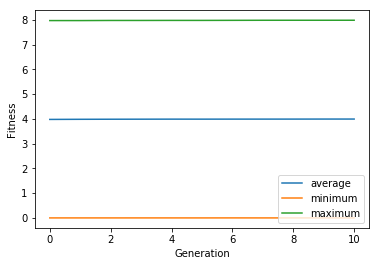

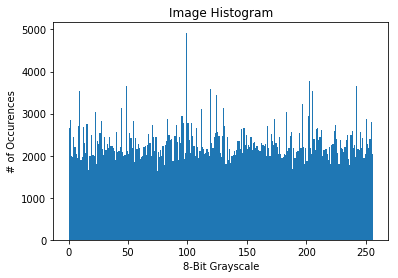

In [38]:
# src = '1.jpg'
# src = 'atom32by32.png'
src = 'flower.jpg'

img = cv2.imread(src,0)

creator.create("FitnessMax", base.Fitness, weights=(1.0,-1.0))
creator.create("Individual", list, fitness=creator.FitnessMax)

# ind = creator.Individual([1, 0, 1, 1, 0])

toolbox = base.Toolbox()

toolbox.register("attr_bool", generate_key, 256)
toolbox.register("individual", tools.initIterate, creator.Individual, toolbox.attr_bool)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)

def evalOneMax(individual):
    return sum(individual),

def evalEntropy(individual):
#     two_bit_crypt = two_dim_bit_encrypt(img, individual).reshape((len(img),len(img[0])))
#     score = np.mean(entropy(two_bit_crypt, disk(8)))
#     c = scramble_2D(img, individual)
    cc = scramble_2D_bit(img, individual)
    entr = hist_entropy(cc)
    corr = corr_coef_sample(cc)
    return entr, corr

toolbox.register("evaluate", evalEntropy)
toolbox.register("mate", tools.cxPartialyMatched)
toolbox.register("mutate", tools.mutShuffleIndexes, indpb=0.05)
toolbox.register("select", tools.selTournament, tournsize=5)


def sim():
    import numpy
    
    pop = toolbox.population(n=50)
    hof = tools.HallOfFame(1)
    stats = tools.Statistics(lambda ind: ind.fitness.values)
    stats.register("avg", numpy.mean)
    stats.register("min", numpy.min)
    stats.register("max", numpy.max)
    
    pop, logbook = algorithms.eaSimple(pop, toolbox, cxpb=0.5, mutpb=0.2, ngen=10, stats=stats, halloffame=hof, verbose=True)
    
    return pop, logbook, hof


pop, log, hof = sim()
print("Best individual is: %s\nwith fitness: %s" % (hof[0], hof[0].fitness))

gen, avg, min_, max_ = log.select("gen", "avg", "min", "max")
plt.plot(gen, avg, label="average")
plt.plot(gen, min_, label="minimum")
plt.plot(gen, max_, label="maximum")
plt.xlabel("Generation")
plt.ylabel("Fitness")
plt.legend(loc="lower right")
plt.show()

def plot_hist(image, title=None, save=None):
    
    bins = [x for x in range(0,257)]

    plt.hist(image.flatten(), bins=bins)
    plt.title(title if type(title) is str else 'Image Histogram')
    plt.xlabel('8-Bit Grayscale')
    plt.ylabel('# of Occurences')
    if (type(save) is str ):
        plt.savefig(save)
    plt.show()
    
plot_hist(scramble_2D_bit(img, hof[0]), save='crypt.png')

cv2.imshow('HOF', scramble_2D_bit(img, hof[0]))
cv2.imwrite('encrypted.png',scramble_2D_bit(img, hof[0]))
cv2.waitKey(0)
cv2.destroyAllWindows()